<a href="https://colab.research.google.com/github/peterbabulik/QuantumWalker/blob/main/QW_on_IBM_heron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qiskit qiskit-ibm-runtime qiskit-aer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 359.9/359.9 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.9/434.9 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0

Successfully imported Qiskit Runtime modules.
Initializing IBM QiskitRuntimeService with token...


<ipython-input-2-51107f691858>:43: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, ibm_cloud will be the only valid channel. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(channel=IBM_QUANTUM_CHANNEL_DIRECT, instance=IBM_QUANTUM_INSTANCE_DIRECT, token=IBM_QUANTUM_TOKEN_DIRECT)


IBM QiskitRuntimeService initialized.

Attempting to get QPU backend: ibm_brisbane...
Selected QPU: ibm_brisbane (Status: active)

--- Test1_InitMeasure Circuit ---
             init_state ┌─┐      
  p_0: ──────────░──────┤M├──────
       ┌───┐     ░      └╥┘┌─┐   
  p_1: ┤ X ├─────░───────╫─┤M├───
       └───┘     ░       ║ └╥┘┌─┐
    c: ──────────░───────╫──╫─┤M├
                 ░       ║  ║ └╥┘
cr1: 3/══════════════════╩══╩══╩═
                         0  1  2 

--- Test2_Init_H_Measure Circuit ---
             init_state       H_coin ┌─┐      
  p_0: ──────────░──────────────░────┤M├──────
       ┌───┐     ░              ░    └╥┘┌─┐   
  p_1: ┤ X ├─────░──────────────░─────╫─┤M├───
       └───┘     ░      ┌───┐   ░     ║ └╥┘┌─┐
    c: ──────────░──────┤ H ├───░─────╫──╫─┤M├
                 ░      └───┘   ░     ║  ║ └╥┘
cr2: 3/═══════════════════════════════╩══╩══╩═
                                      0  1  2 

--- Test3_Init_H_ShiftA_Measure Circuit ---
             init_state

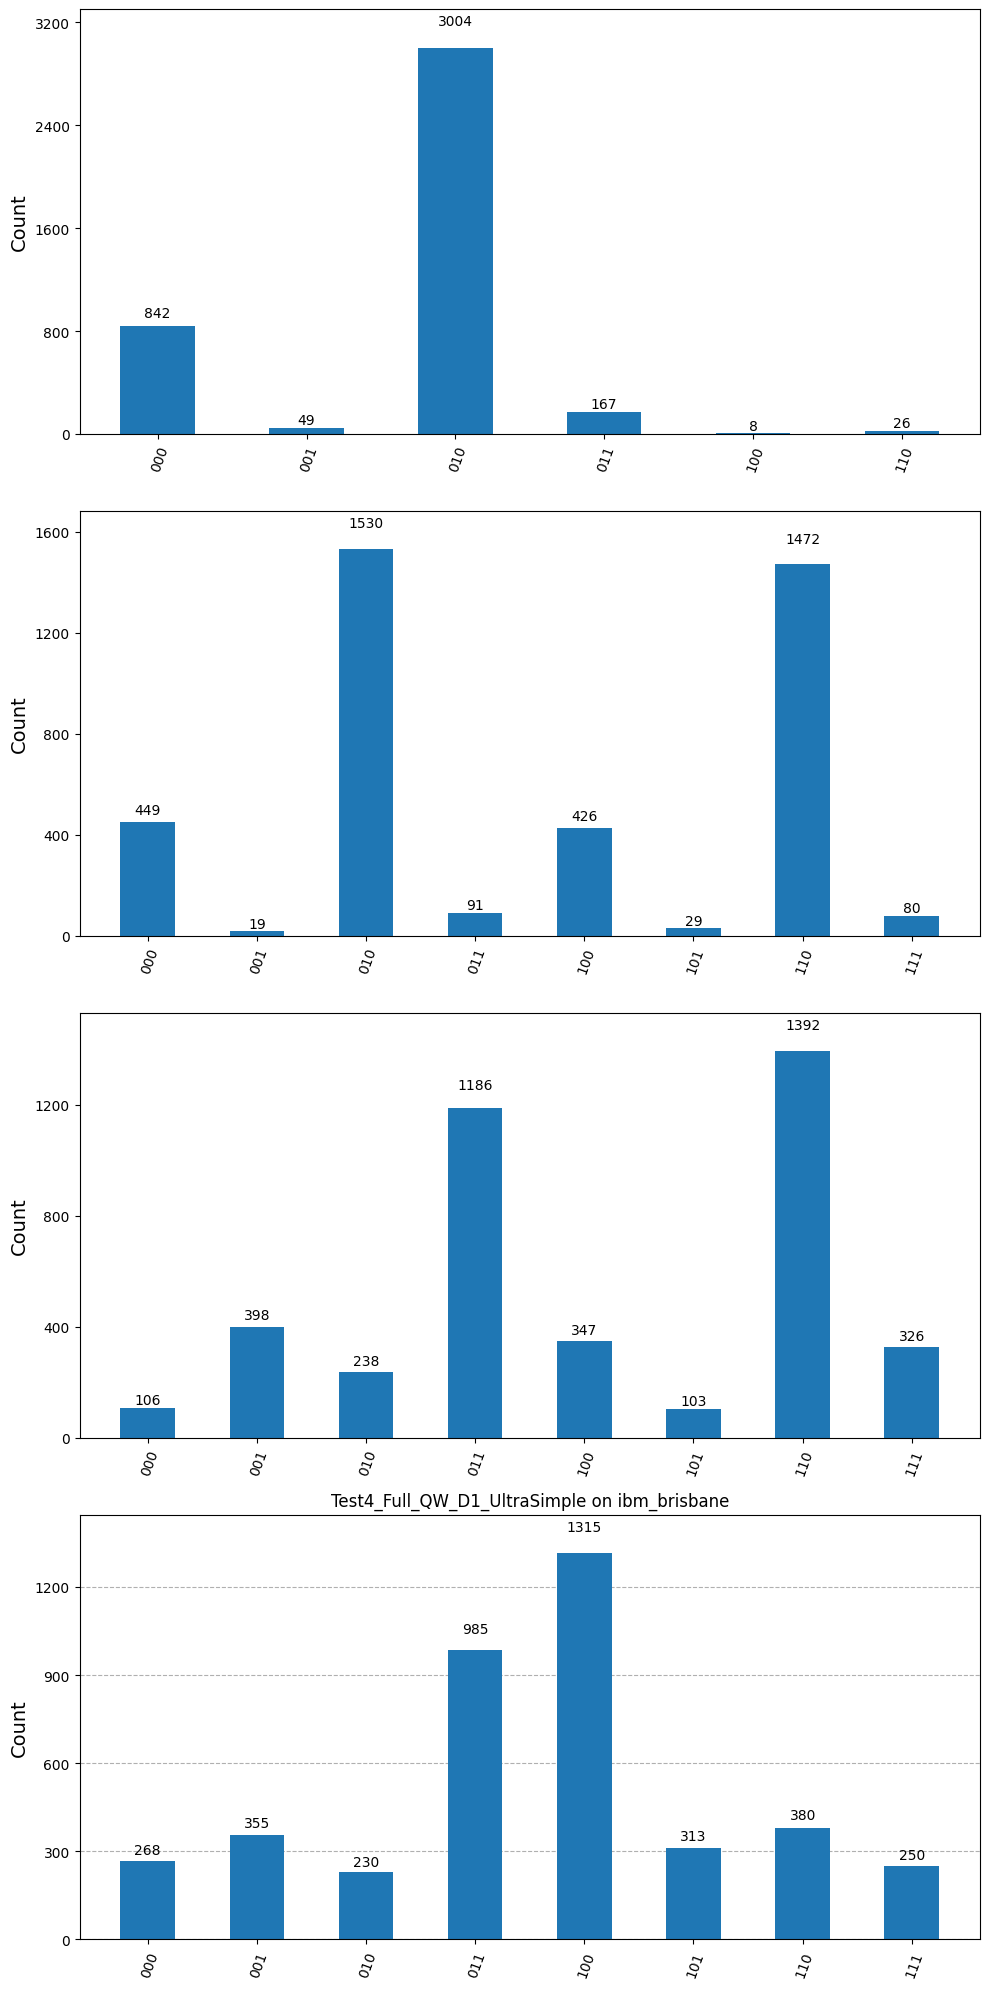


EXPERIMENT CONCLUDED. Invalidate token '99dd752798...' now.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mpl_colors
import time
import os
import traceback

# Qiskit imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

# Modern IBM Quantum access
try:
    from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, Session
    from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
    from qiskit_ibm_runtime.ibm_backend import IBMBackend as IBMRuntimeBackend
    qiskit_runtime_available = True
    print("Successfully imported Qiskit Runtime modules.")
except ImportError:
    print("CRITICAL WARNING: qiskit_ibm_runtime could not be imported.")
    QiskitRuntimeService = None; Sampler = None; Session = None; generate_preset_pass_manager = None
    IBMRuntimeBackend = None
    qiskit_runtime_available = False

# --- Parameters ---
N_SITES = 4
N_POS_QUBITS = (N_SITES - 1).bit_length() if N_SITES > 0 else 0
N_COIN_QUBITS = 1
TOTAL_QUBITS_QW = N_POS_QUBITS + N_COIN_QUBITS
INITIAL_POS_VAL = N_SITES // 2 # Start at site 2 (binary 10 for N_SITES=4)
INITIAL_COIN_VAL = 0

# --- IBM Quantum API Token ---
IBM_QUANTUM_TOKEN_DIRECT = 'API KY HERE'
IBM_QUANTUM_CHANNEL_DIRECT = 'ibm_quantum'
IBM_QUANTUM_INSTANCE_DIRECT = 'ibm-q/open/main'

service = None
if qiskit_runtime_available:
    try:
        print(f"Initializing IBM QiskitRuntimeService with token...")
        service = QiskitRuntimeService(channel=IBM_QUANTUM_CHANNEL_DIRECT, instance=IBM_QUANTUM_INSTANCE_DIRECT, token=IBM_QUANTUM_TOKEN_DIRECT)
        print("IBM QiskitRuntimeService initialized.")
    except Exception as e: print(f"ERROR initializing QiskitRuntimeService: {e}"); service = None
else: print("qiskit_ibm_runtime not available.")

# --- Select Backend ---
backend = None
backend_name_to_print = "AerSimulator (local)"
backend_target_name = 'ibm_brisbane'

if service:
    try:
        print(f"\nAttempting to get QPU backend: {backend_target_name}...")
        qpu_obj = service.backend(backend_target_name)
        if qpu_obj and qpu_obj.status().operational:
            backend = qpu_obj; backend_name_to_print = backend.name
            print(f"Selected QPU: {backend.name} (Status: {backend.status().status_msg})")
        else: print(f"QPU {backend_target_name} not found/operational."); backend = None
    except Exception as e: print(f"Could not get QPU '{backend_target_name}': {e}"); backend = None

if backend is None:
    print("\nNo QPU. Falling back to AerSimulator.")
    backend = AerSimulator(); backend_name_to_print = "AerSimulator (local)"

# --- Helper to build initial state part of circuit ---
def add_initial_state(qc, pos_q_reg, coin_q_reg, init_pos_val, init_coin_val):
    for i in range(len(pos_q_reg)):
        if (init_pos_val >> i) & 1: qc.x(pos_q_reg[i])
    if len(coin_q_reg) > 0 and init_coin_val == 1: qc.x(coin_q_reg[0])
    qc.barrier(label="init_state")

# --- Circuits for Iterative Debugging ---
circuits_debug = []
circuit_debug_names = []

# Test 1: Initial State -> Measure
pos_q1 = QuantumRegister(N_POS_QUBITS, 'p')
coin_q1 = QuantumRegister(N_COIN_QUBITS, 'c')
cr1 = ClassicalRegister(TOTAL_QUBITS_QW, 'cr1')
qc1_init_measure = QuantumCircuit(pos_q1, coin_q1, cr1, name="Test1_InitMeasure")
add_initial_state(qc1_init_measure, pos_q1, coin_q1, INITIAL_POS_VAL, INITIAL_COIN_VAL)
qc1_init_measure.measure(pos_q1[:] + coin_q1[:], cr1[:])
circuits_debug.append(qc1_init_measure)
circuit_debug_names.append(qc1_init_measure.name)
print(f"\n--- {qc1_init_measure.name} Circuit ---")
print(qc1_init_measure.draw(output='text', fold=-1))

# Test 2: Initial State -> H(coin) -> Measure
pos_q2 = QuantumRegister(N_POS_QUBITS, 'p')
coin_q2 = QuantumRegister(N_COIN_QUBITS, 'c')
cr2 = ClassicalRegister(TOTAL_QUBITS_QW, 'cr2')
qc2_init_h_measure = QuantumCircuit(pos_q2, coin_q2, cr2, name="Test2_Init_H_Measure")
add_initial_state(qc2_init_h_measure, pos_q2, coin_q2, INITIAL_POS_VAL, INITIAL_COIN_VAL)
qc2_init_h_measure.h(coin_q2[0])
qc2_init_h_measure.barrier(label="H_coin")
qc2_init_h_measure.measure(pos_q2[:] + coin_q2[:], cr2[:])
circuits_debug.append(qc2_init_h_measure)
circuit_debug_names.append(qc2_init_h_measure.name)
print(f"\n--- {qc2_init_h_measure.name} Circuit ---")
print(qc2_init_h_measure.draw(output='text', fold=-1))

# Test 3: Initial State -> H(coin) -> First part of Ultra-Simple Shift -> Measure
# Ultra-Simple Shift part 1: X(c); CX(c,p0); X(c); (acts if original coin was 0)
pos_q3 = QuantumRegister(N_POS_QUBITS, 'p')
coin_q3 = QuantumRegister(N_COIN_QUBITS, 'c')
cr3 = ClassicalRegister(TOTAL_QUBITS_QW, 'cr3')
qc3_init_h_shiftA_measure = QuantumCircuit(pos_q3, coin_q3, cr3, name="Test3_Init_H_ShiftA_Measure")
add_initial_state(qc3_init_h_shiftA_measure, pos_q3, coin_q3, INITIAL_POS_VAL, INITIAL_COIN_VAL)
qc3_init_h_shiftA_measure.h(coin_q3[0]); qc3_init_h_shiftA_measure.barrier(label="H_coin")
# Shift Part A
qc3_init_h_shiftA_measure.x(coin_q3[0])
qc3_init_h_shiftA_measure.cx(coin_q3[0], pos_q3[0]) # Assumes N_POS_QUBITS >= 1
qc3_init_h_shiftA_measure.x(coin_q3[0])
qc3_init_h_shiftA_measure.barrier(label="shift_A")
qc3_init_h_shiftA_measure.measure(pos_q3[:] + coin_q3[:], cr3[:])
circuits_debug.append(qc3_init_h_shiftA_measure)
circuit_debug_names.append(qc3_init_h_shiftA_measure.name)
print(f"\n--- {qc3_init_h_shiftA_measure.name} Circuit ---")
print(qc3_init_h_shiftA_measure.draw(output='text', fold=-1))


# Test 4: Initial State -> H(coin) -> Full Ultra-Simple Shift -> Measure (This is D=1 QW)
pos_q4 = QuantumRegister(N_POS_QUBITS, 'p')
coin_q4 = QuantumRegister(N_COIN_QUBITS, 'c')
cr4 = ClassicalRegister(TOTAL_QUBITS_QW, 'cr4')
qc4_full_qw_d1 = QuantumCircuit(pos_q4, coin_q4, cr4, name="Test4_Full_QW_D1_UltraSimple")
add_initial_state(qc4_full_qw_d1, pos_q4, coin_q4, INITIAL_POS_VAL, INITIAL_COIN_VAL)
qc4_full_qw_d1.h(coin_q4[0]); qc4_full_qw_d1.barrier(label="H_coin")
# Full Ultra-Simple Shift
c_qs4, p0_qs4, p1_qs4 = coin_q4[0], pos_q4[0], pos_q4[1] # Specific for N_POS_QUBITS=2
qc4_full_qw_d1.x(c_qs4); qc4_full_qw_d1.cx(c_qs4, p0_qs4); qc4_full_qw_d1.x(c_qs4) # Shift part A
qc4_full_qw_d1.cx(c_qs4, p1_qs4) # Shift part B
qc4_full_qw_d1.barrier(label="full_shift")
qc4_full_qw_d1.measure(pos_q4[:] + coin_q4[:], cr4[:])
circuits_debug.append(qc4_full_qw_d1)
circuit_debug_names.append(qc4_full_qw_d1.name)
print(f"\n--- {qc4_full_qw_d1.name} Circuit ---")
print(qc4_full_qw_d1.draw(output='text', fold=-1))


# --- Transpile and Run ---
print(f"\n--- Transpiling and Running on {backend_name_to_print} ---")
all_counts = []
try:
    shots = 4096
    is_runtime_target = (qiskit_runtime_available and service and backend and
                         IBMRuntimeBackend and isinstance(backend, IBMRuntimeBackend))

    transpiled_circuits_list = []
    if is_runtime_target and generate_preset_pass_manager:
        print("Transpiling circuits for Qiskit Runtime backend...")
        pm = generate_preset_pass_manager(backend=backend, optimization_level=0) # Minimal optimization
        transpiled_circuits_list = pm.run(circuits_debug)
    elif isinstance(backend, AerSimulator):
        print(f"Transpiling circuits for {backend_name_to_print}...")
        transpiled_circuits_list = transpile(circuits_debug, backend=backend, optimization_level=0)
    else:
        print(f"Using original circuits."); transpiled_circuits_list = circuits_debug

    for i, tc in enumerate(transpiled_circuits_list):
        print(f"  Circuit '{circuits_debug[i].name}' depth original: {circuits_debug[i].depth()}, transpiled: {tc.depth()}")

    if is_runtime_target and Sampler and Session:
        print(f"Using SamplerV2 for {backend.name}")
        pubs = [(circ,) for circ in transpiled_circuits_list]
        with Session(backend=backend) as session:
            sampler = Sampler()
            job = sampler.run(pubs, shots=shots)
            print(f"Job ID: {job.job_id()} submitted.")
            result = job.result()
            print("Processing SamplerV2 results...")
            if result and len(result) == len(circuits_debug):
                for i_pub, pub_result in enumerate(result):
                    creg_name = circuits_debug[i_pub].cregs[0].name
                    current_counts = {}
                    if hasattr(pub_result.data, creg_name):
                        bit_array_obj = getattr(pub_result.data, creg_name)
                        if bit_array_obj: current_counts = bit_array_obj.get_counts()
                    elif hasattr(pub_result.data, 'meas'):
                         bit_array_obj = pub_result.data.meas
                         if bit_array_obj: current_counts = bit_array_obj.get_counts()
                    all_counts.append(current_counts)
                    print(f"  Counts for circuit '{circuits_debug[i_pub].name}': {current_counts}")
            else: print("ERROR: Job result issue."); all_counts = [{} for _ in circuits_debug]
    elif isinstance(backend, AerSimulator):
        print(f"Using legacy backend.run() for {backend_name_to_print}")
        job = backend.run(transpiled_circuits_list, shots=shots)
        result = job.result()
        for i_qc in range(len(transpiled_circuits_list)):
            all_counts.append(result.get_counts(i_qc))
    else: print("ERROR: No suitable execution path."); all_counts = [{} for _ in circuits_debug]

    print("\n--- Combined Results for Iterative Debugging ---")
    fig, axs = plt.subplots(len(all_counts), 1, figsize=(10, 5 * len(all_counts)))
    if len(all_counts) == 1: axs = [axs] # Make iterable

    for i, counts_this_run in enumerate(all_counts):
        title = f"{circuit_debug_names[i]} on {backend_name_to_print}"
        if counts_this_run:
            plot_histogram(counts_this_run, ax=axs[i], title=title)
        else:
            axs[i].set_title(f"{title} (No Counts)"); axs[i].text(0.5,0.5,"No Counts", ha="center")

    plt.tight_layout(); plt.show()

except Exception as e: print(f"Error: {e}"); traceback.print_exc()
finally: print(f"\nEXPERIMENT CONCLUDED. Invalidate token '{IBM_QUANTUM_TOKEN_DIRECT[:10]}...' now.")

Successfully imported Qiskit Runtime modules.
Attempting to initialize IBM QiskitRuntimeService directly with provided token for instance: ibm-q/open/main


<ipython-input-3-6b4407f5f3e0>:40: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, ibm_cloud will be the only valid channel. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(


IBM QiskitRuntimeService initialized directly with provided token.

Available backends from QiskitRuntimeService (will attempt to filter for simulators first):

Attempting to get a 'least_busy' SIMULATOR from QiskitRuntimeService (min 3 qubits)...
Error using service.least_busy(simulator=True): 'No backend matches the criteria.'

Cloud simulator not found or selected. Attempting to get QPU backend: ibm_brisbane...
Selected QPU backend for Qiskit Runtime: ibm_brisbane (Qubits: 127, Status: <qiskit_ibm_runtime.models.backend_status.BackendStatus object at 0x7919397add10>)

N_SITES=3, N_POS_QUBITS=2, Target initial_pos_val=1

Building QW circuit with Depth=2...

--- Generated QW Circuit ---
            ┌───┐ init      ┌───┐ shift_op  step_s0      ┌───┐ shift_op ┌─┐      
     pos_0: ┤ X ├──░────────┤ X ├────░─────────░─────────┤ X ├────░─────┤M├──────
            └───┘  ░        └─┬─┘    ░         ░         └─┬─┘    ░     └╥┘┌─┐   
     pos_1: ───────░──────────┼──────░─────────░─────────

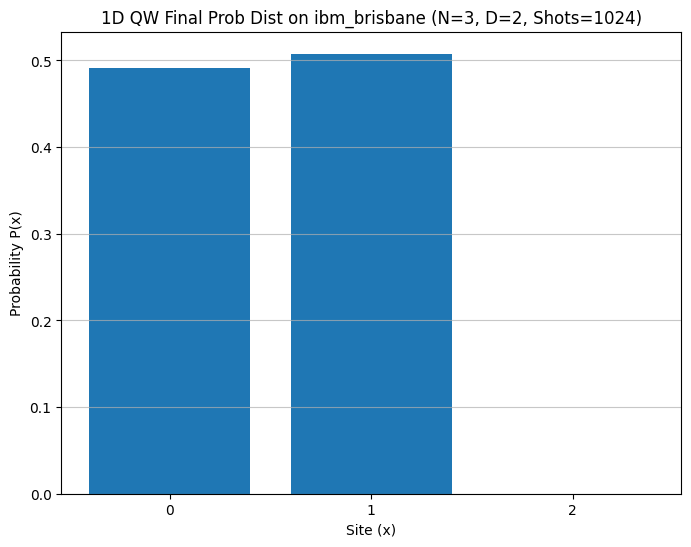


EXPERIMENT CONCLUDED. Please remember to invalidate the API token '99dd752798...' (used directly in this script) on the IBM Quantum website: https://quantum.ibm.com/account


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mpl_colors
import time
import os

# Qiskit imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator

# Modern IBM Quantum access
try:
    from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, Session
    from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
    from qiskit_ibm_runtime.ibm_backend import IBMBackend as IBMRuntimeBackend
    qiskit_runtime_available = True
    print("Successfully imported Qiskit Runtime modules.")
except ImportError:
    print("CRITICAL WARNING: qiskit_ibm_runtime could not be imported. IBM Quantum execution will fail.")
    QiskitRuntimeService = None; Sampler = None; Session = None; generate_preset_pass_manager = None
    IBMRuntimeBackend = None
    qiskit_runtime_available = False

# --- Parameters for this test ---
N_SITES = 3
N_POS_QUBITS = (N_SITES - 1).bit_length() if N_SITES > 0 else 0
N_COIN_QUBITS = 1
TOTAL_QUBITS = N_POS_QUBITS + N_COIN_QUBITS
DEPTH = 2    # Very shallow depth for QPU test

# --- IBM Quantum API Token and Instance Details ---
IBM_QUANTUM_TOKEN_DIRECT = 'API KEY HERE'
IBM_QUANTUM_CHANNEL_DIRECT = 'ibm_quantum'
IBM_QUANTUM_INSTANCE_DIRECT = 'ibm-q/open/main'

service = None
if qiskit_runtime_available:
    try:
        print(f"Attempting to initialize IBM QiskitRuntimeService directly with provided token for instance: {IBM_QUANTUM_INSTANCE_DIRECT}")
        service = QiskitRuntimeService(
            channel=IBM_QUANTUM_CHANNEL_DIRECT,
            instance=IBM_QUANTUM_INSTANCE_DIRECT,
            token=IBM_QUANTUM_TOKEN_DIRECT
        )
        print("IBM QiskitRuntimeService initialized directly with provided token.")
    except Exception as e:
        print(f"ERROR: Could not initialize QiskitRuntimeService directly with token: {e}")
        service = None
else:
    print("qiskit_ibm_runtime package is not available. Cannot use IBM Quantum Primitives.")

# --- Select Backend ---
backend = None
backend_name_to_print = "AerSimulator (local)"
backend_target_name = 'ibm_brisbane'

if service:
    print("\nAvailable backends from QiskitRuntimeService (will attempt to filter for simulators first):")
    # for backend_obj_info in service.backends():
    #     print(f"  - Name: {backend_obj_info.name}, Simulator: {backend_obj_info.simulator}, Qubits: {backend_obj_info.num_qubits}, Status: {backend_obj_info.status}")
    try:
        print(f"\nAttempting to get a 'least_busy' SIMULATOR from QiskitRuntimeService (min {TOTAL_QUBITS} qubits)...")
        runtime_simulator_backend = service.least_busy(min_num_qubits=TOTAL_QUBITS, simulator=True, operational=None)
        if runtime_simulator_backend:
            backend = runtime_simulator_backend
            backend_name_to_print = backend.name
            print(f"Selected CLOUD SIMULATOR for Qiskit Runtime: {backend.name} (Qubits: {backend.num_qubits})")
        else:
            print("service.least_busy(simulator=True) did not return a backend.")
    except Exception as e_least_busy_sim:
        print(f"Error using service.least_busy(simulator=True): {e_least_busy_sim}")

    if backend is None:
        print(f"\nCloud simulator not found or selected. Attempting to get QPU backend: {backend_target_name}...")
        try:
            qpu_backend_obj = service.backend(backend_target_name)
            if qpu_backend_obj:
                backend = qpu_backend_obj
                backend_name_to_print = backend.name
                print(f"Selected QPU backend for Qiskit Runtime: {backend.name} (Qubits: {backend.num_qubits}, Status: {backend.status()})")
                if hasattr(backend, 'status') and callable(backend.status) and backend.status().status_msg != 'active':
                    print(f"WARNING: QPU {backend.name} status is {backend.status().status_msg}. May not be ideal for running jobs.")
            else:
                print(f"QPU backend {backend_target_name} not found or not available via service.")
                backend = None
        except Exception as e_qpu:
            print(f"Could not get QPU backend '{backend_target_name}': {e_qpu}")

if backend is None:
    print("\nNo cloud backend successfully obtained. Falling back to local AerSimulator.")
    backend = AerSimulator()
    backend_name_to_print = "AerSimulator (local)"

# --- Define Qubit Registers and Circuit ---
pos_q = QuantumRegister(N_POS_QUBITS, name='pos')
coin_q = QuantumRegister(N_COIN_QUBITS, name='coin')
cr_combined = ClassicalRegister(N_POS_QUBITS + N_COIN_QUBITS, name='meas_out')
qc = QuantumCircuit(pos_q, coin_q, cr_combined)

# --- Initial State ---
initial_pos_val = N_SITES // 2
print(f"\nN_SITES={N_SITES}, N_POS_QUBITS={N_POS_QUBITS}, Target initial_pos_val={initial_pos_val}")
for i in range(N_POS_QUBITS):
    if (initial_pos_val >> i) & 1: qc.x(pos_q[i])
qc.barrier(label="init")

# --- QW Step Definition (Ultra-Simplified Shift) ---
def apply_coin_step_qiskit(circuit, coin_qubit_obj):
    circuit.h(coin_qubit_obj)

def apply_shift_step_qiskit(circuit, coin_qubit_obj, pos_register_list, num_sites):
    if pos_register_list:
        circuit.cx(coin_qubit_obj, pos_register_list[0])
    circuit.barrier(label="shift_op")

# --- Evolution Loop ---
print(f"\nBuilding QW circuit with Depth={DEPTH}...")
for step in range(DEPTH):
    apply_coin_step_qiskit(qc, coin_q[0])
    apply_shift_step_qiskit(qc, coin_q[0], pos_q, N_SITES)
    if step < DEPTH - 1: qc.barrier(label=f"step_s{step}")

# --- Measurement ---
qc.measure(pos_q[:] + coin_q[:], cr_combined[:])

print("\n--- Generated QW Circuit ---")
try: print(qc.draw(output='text', fold=-1))
except Exception as e_draw: print(f"Could not draw circuit: {e_draw}")

# --- Transpile and Run ---
print(f"\n--- Transpiling and Running on {backend_name_to_print} ---")
counts = {}
try:
    shots = 1024
    isa_circuit = qc
    is_runtime_target = False
    if qiskit_runtime_available and service and backend:
        if IBMRuntimeBackend and isinstance(backend, IBMRuntimeBackend): is_runtime_target = True
        elif hasattr(backend, 'provider') and "runtime" in str(type(backend.provider)).lower() and backend.name != "aer_simulator": is_runtime_target = True

    if is_runtime_target and generate_preset_pass_manager is not None:
        print("Transpiling for Qiskit Runtime backend using preset pass manager...")
        pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
        isa_circuit = pm.run(qc)
        print(f"QW circuit depth original: {qc.depth()}, transpiled (ISA): {isa_circuit.depth()}")
    elif isinstance(backend, AerSimulator):
        print(f"Basic transpilation for {backend_name_to_print}...")
        isa_circuit = transpile(qc, backend=backend, optimization_level=1)
        print(f"QW circuit depth original: {qc.depth()}, transpiled: {isa_circuit.depth()}")
    else:
        print(f"Using original circuit for {backend_name_to_print} (depth: {qc.depth()}).")

    if is_runtime_target and Sampler is not None and Session is not None :
        print(f"Using QiskitRuntimeService SamplerV2 for backend: {backend.name}")
        with Session(backend=backend) as session:
            sampler = Sampler()
            pub = (isa_circuit,)
            job = sampler.run([pub], shots=shots)
            print(f"Job ID: {job.job_id()} submitted to Qiskit Runtime.")
            print("Waiting for results...")
            result = job.result()

            print("Processing SamplerV2 results...")
            if result and len(result) > 0:
                pub_result = result[0]
                classical_register_name_in_circuit = cr_combined.name
                if hasattr(pub_result.data, classical_register_name_in_circuit):
                    bit_array_obj = getattr(pub_result.data, classical_register_name_in_circuit)
                    if bit_array_obj is not None:
                        counts = bit_array_obj.get_counts()
                        print(f"Counts obtained from '{classical_register_name_in_circuit}' BitArray.")
                    else:
                        print(f"WARNING: Data for classical register '{classical_register_name_in_circuit}' is None.")
                        counts = {}
                elif hasattr(pub_result.data, 'meas'):
                    bit_array_obj = pub_result.data.meas
                    if bit_array_obj is not None:
                        counts = bit_array_obj.get_counts()
                        print("Counts obtained from 'meas' BitArray (default for measure_all).")
                    else:
                        print("WARNING: Data for 'meas' is None.")
                        counts = {}
                else:
                    print(f"WARNING: No '{classical_register_name_in_circuit}' or 'meas' field in SamplerV2 data. DataBin attributes: {dir(pub_result.data)}")
                    counts = {}
            else: print("ERROR: Job result is None or empty from SamplerV2."); counts = {}
    elif isinstance(backend, AerSimulator):
        print(f"Using legacy backend.run() for {backend_name_to_print}")
        job = backend.run(isa_circuit, shots=shots)
        result = job.result()
        counts = result.get_counts(0)
    else:
        print(f"ERROR: No suitable execution path found. Backend: {backend.name if backend else 'None'}")
        counts = {}

    print("\n--- Results ---")
    print("Counts:", counts)

    # --- Process and Analyze Results ---
    print("\n--- Analysis (Example) ---")
    prob_dist_x = np.zeros(N_SITES)
    if counts:
        for bitstring, count_val in counts.items():
            if len(bitstring) == TOTAL_QUBITS:
                try:
                    # Qiskit bitstring "c_N-1 ... c_0". c_0 is for qubit 0.
                    # Our circuit qubits: pos_q[0]...pos_q[N_POS-1], coin_q[0]
                    # Classical bits in cr_combined map to these in order.
                    # cr_combined[0] <- pos_q[0]
                    # cr_combined[1] <- pos_q[1] (if N_POS_QUBITS=2)
                    # cr_combined[2] <- coin_q[0] (if N_POS_QUBITS=2, N_COIN_QUBITS=1)
                    # Bitstring from get_counts(): "b_coin b_pos_MSB ... b_pos_LSB"
                    # For 3 total qubits (2 pos, 1 coin): "b_c0 b_p1 b_p0"
                    # The string has coin bit first, then position bits.

                    # Correct parsing assuming string is "c p" if split, or "cp" if not.
                    # For single string from SamplerV2 measure_all into one register:
                    # The string is MSB...LSB according to classical bit indices.
                    # cr_combined[0] is LSB. cr_combined[TOTAL_QUBITS-1] is MSB.
                    # cr_combined[0] to cr_combined[N_POS_QUBITS-1] are position.
                    # cr_combined[N_POS_QUBITS] to cr_combined[TOTAL_QUBITS-1] are coin.

                    # Let's assume string is c_{N_C-1}..c_0 p_{N_P-1}..p_0 from .get_counts() on BitArray
                    # if the original cr_combined was structured that way.
                    # However, measure_all maps q_i to c_i.
                    # circuit.qubits = [p0,p1.., c0]
                    # measure_all string: "val_c0 val_p(N-1) ... val_p0" (MSB is coin)

                    pos_binary_str = bitstring[N_COIN_QUBITS:]
                    coin_binary_str = bitstring[:N_COIN_QUBITS]

                    measured_pos = int(pos_binary_str, 2)

                    if 0 <= measured_pos < N_SITES:
                        prob_dist_x[measured_pos] += count_val / shots
                    else: print(f"Warning: Parsed pos {measured_pos} from '{bitstring}' out of bounds.")
                except ValueError as e_parse: print(f"Warning: Could not parse bitstring '{bitstring}': {e_parse}")
                except IndexError as e_idx: print(f"Warning: Index error parsing bitstring '{bitstring}': {e_idx}")
            # Handling for AerSimulator's space-separated "coin_val pos_val"
            elif ' ' in bitstring and backend_name_to_print == "AerSimulator (local)":
                parts = bitstring.split(' ')
                if len(parts) == 2:
                    coin_str_part = parts[0]
                    pos_str_part = parts[1]
                    try:
                        measured_pos = int(pos_str_part, 2)
                        if 0 <= measured_pos < N_SITES:
                            prob_dist_x[measured_pos] += count_val / shots
                    except ValueError: pass # Ignore if parsing fails
            else: print(f"Unexpected bitstring format/length: '{bitstring}' for backend {backend_name_to_print}")

    if counts:
        plt.figure(figsize=(max(8, N_SITES*1.5),6))
        plt.bar(np.arange(N_SITES), prob_dist_x, width=0.8)
        plt.xlabel("Site (x)")
        plt.ylabel("Probability P(x)")
        plt.title(f"1D QW Final Prob Dist on {backend_name_to_print} (N={N_SITES}, D={DEPTH}, Shots={shots})")
        plt.xticks(np.arange(N_SITES))
        plt.grid(axis='y', alpha=0.7)
        plt.show()
    else: print("No counts data to plot.")

except Exception as main_e:
    print(f"An error occurred in the main script: {main_e}")
    import traceback
    traceback.print_exc()
finally:
    print(f"\nEXPERIMENT CONCLUDED. Please remember to invalidate the API token "
          f"'{IBM_QUANTUM_TOKEN_DIRECT[:10]}...' (used directly in this script) "
          f"on the IBM Quantum website: https://quantum.ibm.com/account")

Successfully imported Qiskit Runtime modules.
Attempting to initialize IBM QiskitRuntimeService directly with provided token for instance: ibm-q/open/main


<ipython-input-4-e9af52f02a30>:40: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, ibm_cloud will be the only valid channel. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(


IBM QiskitRuntimeService initialized directly with provided token.

Available backends from QiskitRuntimeService (will attempt to filter for simulators first):

Attempting to get a 'least_busy' SIMULATOR from QiskitRuntimeService (min 3 qubits)...
Error using service.least_busy(simulator=True): 'No backend matches the criteria.'

Cloud simulator not found or selected. Attempting to get QPU backend: ibm_brisbane...
Selected QPU backend for Qiskit Runtime: ibm_brisbane (Qubits: 127, Status: active)

N_SITES=3, N_POS_QUBITS=2, Target initial_pos_val=1

Building QW circuit with Depth=2...

--- Generated QW Circuit ---
            ┌───┐ init      ┌───┐ shift_op  step_s0      ┌───┐ shift_op ┌─┐      
     pos_0: ┤ X ├──░────────┤ X ├────░─────────░─────────┤ X ├────░─────┤M├──────
            └───┘  ░        └─┬─┘    ░         ░         └─┬─┘    ░     └╥┘┌─┐   
     pos_1: ───────░──────────┼──────░─────────░───────────┼──────░──────╫─┤M├───
                   ░   ┌───┐  │      ░         ░  

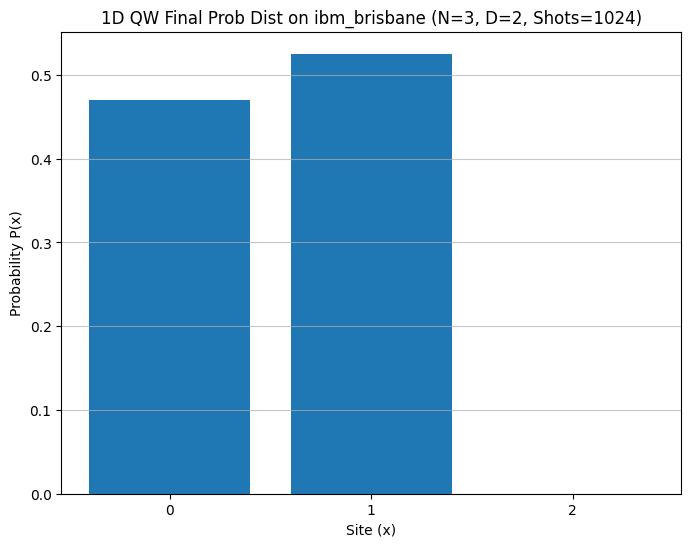


EXPERIMENT CONCLUDED. Please remember to invalidate the API token '99dd752798...' (used directly in this script) on the IBM Quantum website: https://quantum.ibm.com/account


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mpl_colors
import time
import os

# Qiskit imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator

# Modern IBM Quantum access
try:
    from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, Session
    from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
    from qiskit_ibm_runtime.ibm_backend import IBMBackend as IBMRuntimeBackend
    qiskit_runtime_available = True
    print("Successfully imported Qiskit Runtime modules.")
except ImportError:
    print("CRITICAL WARNING: qiskit_ibm_runtime could not be imported. IBM Quantum execution will fail.")
    QiskitRuntimeService = None; Sampler = None; Session = None; generate_preset_pass_manager = None
    IBMRuntimeBackend = None
    qiskit_runtime_available = False

# --- Parameters for this test ---
N_SITES = 3
N_POS_QUBITS = (N_SITES - 1).bit_length() if N_SITES > 0 else 0
N_COIN_QUBITS = 1
TOTAL_QUBITS = N_POS_QUBITS + N_COIN_QUBITS
DEPTH = 2    # Very shallow depth for QPU test

# --- IBM Quantum API Token and Instance Details ---
IBM_QUANTUM_TOKEN_DIRECT = 'API KEY HERE'
IBM_QUANTUM_CHANNEL_DIRECT = 'ibm_quantum'
IBM_QUANTUM_INSTANCE_DIRECT = 'ibm-q/open/main'

service = None
if qiskit_runtime_available:
    try:
        print(f"Attempting to initialize IBM QiskitRuntimeService directly with provided token for instance: {IBM_QUANTUM_INSTANCE_DIRECT}")
        service = QiskitRuntimeService(
            channel=IBM_QUANTUM_CHANNEL_DIRECT,
            instance=IBM_QUANTUM_INSTANCE_DIRECT,
            token=IBM_QUANTUM_TOKEN_DIRECT
        )
        print("IBM QiskitRuntimeService initialized directly with provided token.")
    except Exception as e:
        print(f"ERROR: Could not initialize QiskitRuntimeService directly with token: {e}")
        service = None
else:
    print("qiskit_ibm_runtime package is not available. Cannot use IBM Quantum Primitives.")

# --- Select Backend ---
backend = None
backend_name_to_print = "AerSimulator (local)"
backend_target_name = 'ibm_brisbane'

if service:
    print("\nAvailable backends from QiskitRuntimeService (will attempt to filter for simulators first):")
    # for backend_obj_info in service.backends(): # Can be verbose
    #     print(f"  - Name: {backend_obj_info.name}, Simulator: {backend_obj_info.simulator}, Qubits: {backend_obj_info.num_qubits}, Status: {backend_obj_info.status()}")
    try:
        print(f"\nAttempting to get a 'least_busy' SIMULATOR from QiskitRuntimeService (min {TOTAL_QUBITS} qubits)...")
        runtime_simulator_backend = service.least_busy(min_num_qubits=TOTAL_QUBITS, simulator=True, operational=None)
        if runtime_simulator_backend:
            backend = runtime_simulator_backend
            backend_name_to_print = backend.name
            print(f"Selected CLOUD SIMULATOR for Qiskit Runtime: {backend.name} (Qubits: {backend.num_qubits})")
        else:
            print("service.least_busy(simulator=True) did not return a backend.")
    except Exception as e_least_busy_sim:
        print(f"Error using service.least_busy(simulator=True): {e_least_busy_sim}")

    if backend is None:
        print(f"\nCloud simulator not found or selected. Attempting to get QPU backend: {backend_target_name}...")
        try:
            qpu_backend_obj = service.backend(backend_target_name)
            if qpu_backend_obj:
                backend = qpu_backend_obj
                backend_name_to_print = backend.name
                # Access status via status() method
                current_status = backend.status()
                print(f"Selected QPU backend for Qiskit Runtime: {backend.name} (Qubits: {backend.num_qubits}, Status: {current_status.status_msg})")
                if current_status.status_msg != 'active':
                    print(f"WARNING: QPU {backend.name} status is {current_status.status_msg}. May not be ideal for running jobs.")
            else:
                print(f"QPU backend {backend_target_name} not found or not available via service.")
                backend = None
        except Exception as e_qpu:
            print(f"Could not get QPU backend '{backend_target_name}': {e_qpu}")

if backend is None:
    print("\nNo cloud backend successfully obtained. Falling back to local AerSimulator.")
    backend = AerSimulator()
    backend_name_to_print = "AerSimulator (local)"

# --- Define Qubit Registers and Circuit ---
pos_q = QuantumRegister(N_POS_QUBITS, name='pos')
coin_q = QuantumRegister(N_COIN_QUBITS, name='coin')
cr_combined = ClassicalRegister(N_POS_QUBITS + N_COIN_QUBITS, name='meas_out')
qc = QuantumCircuit(pos_q, coin_q, cr_combined)

# --- Initial State ---
initial_pos_val = N_SITES // 2
print(f"\nN_SITES={N_SITES}, N_POS_QUBITS={N_POS_QUBITS}, Target initial_pos_val={initial_pos_val}")
# Qiskit LSB is q[0]. To set state |...p1p0>, if initial_pos_val is integer:
for i in range(N_POS_QUBITS):
    if (initial_pos_val >> i) & 1: # if i-th bit (from right) is 1
        qc.x(pos_q[i]) # Flip the i-th position qubit (qiskit index)
# Initial coin state |0> (default)
qc.barrier(label="init")

# --- QW Step Definition (Ultra-Simplified Shift) ---
def apply_coin_step_qiskit(circuit, coin_qubit_obj):
    circuit.h(coin_qubit_obj)

def apply_shift_step_qiskit(circuit, coin_qubit_obj, pos_register_list, num_sites):
    # This is an ULTRA-SIMPLIFIED shift, NOT a proper QW shift.
    # If coin is |1>, flip the LSB of position.
    if pos_register_list: # Check if there are position qubits
        circuit.cx(coin_qubit_obj, pos_register_list[0]) # Control: coin, Target: pos_q[0]
    circuit.barrier(label="shift_op")

# --- Evolution Loop ---
print(f"\nBuilding QW circuit with Depth={DEPTH}...")
for step in range(DEPTH):
    apply_coin_step_qiskit(qc, coin_q[0])
    apply_shift_step_qiskit(qc, coin_q[0], pos_q, N_SITES)
    if step < DEPTH - 1: qc.barrier(label=f"step_s{step}")

# --- Measurement ---
# Measure all quantum registers into the single classical register
# Qubits are measured in the order they are provided in the first list
# into classical bits in the order of the second list.
# circuit.qubits = [pos_q[0], pos_q[1], coin_q[0]] (for N_POS_QUBITS=2)
# cr_combined has N_POS_QUBITS + N_COIN_QUBITS bits
# We want cr_combined[0] to get pos_q[0], cr_combined[1] gets pos_q[1],
# cr_combined[N_POS_QUBITS] gets coin_q[0]
qc.measure(pos_q[:] + coin_q[:], cr_combined[:])

print("\n--- Generated QW Circuit ---")
try: print(qc.draw(output='text', fold=-1))
except Exception as e_draw: print(f"Could not draw circuit: {e_draw}")

# --- Transpile and Run ---
print(f"\n--- Transpiling and Running on {backend_name_to_print} ---")
counts = {}
try:
    shots = 1024
    isa_circuit = qc
    is_runtime_target = False
    if qiskit_runtime_available and service and backend:
        if IBMRuntimeBackend and isinstance(backend, IBMRuntimeBackend): is_runtime_target = True
        # Check if it's a runtime simulator not from Aer
        elif backend.name != "aer_simulator" and hasattr(backend, 'provider') and "runtime" in str(type(backend.provider)).lower():
             is_runtime_target = True


    if is_runtime_target and generate_preset_pass_manager is not None:
        print("Transpiling for Qiskit Runtime backend using preset pass manager...")
        pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
        isa_circuit = pm.run(qc)
        print(f"QW circuit depth original: {qc.depth()}, transpiled (ISA): {isa_circuit.depth()}")
    elif isinstance(backend, AerSimulator):
        print(f"Basic transpilation for {backend_name_to_print}...")
        isa_circuit = transpile(qc, backend=backend, optimization_level=1)
        print(f"QW circuit depth original: {qc.depth()}, transpiled: {isa_circuit.depth()}")
    else:
        print(f"Using original circuit for {backend_name_to_print} (depth: {qc.depth()}). Assuming it's already compatible or a simulator.")

    if is_runtime_target and Sampler is not None and Session is not None :
        print(f"Using QiskitRuntimeService SamplerV2 for backend: {backend.name}")
        with Session(backend=backend) as session:
            sampler = Sampler()
            pub = (isa_circuit,)
            job = sampler.run([pub], shots=shots)
            print(f"Job ID: {job.job_id()} submitted to Qiskit Runtime.")
            print("Waiting for results...")
            result = job.result()

            print("Processing SamplerV2 results...")
            if result and len(result) > 0:
                pub_result = result[0]
                # Classical register for measure_all is usually 'meas' or the name of the creg if specified at measure_all
                # We used cr_combined which is named 'meas_out'
                if hasattr(pub_result.data, cr_combined.name):
                    bit_array_obj = getattr(pub_result.data, cr_combined.name)
                    if bit_array_obj is not None:
                        counts = bit_array_obj.get_counts()
                        print(f"Counts obtained from '{cr_combined.name}' BitArray.")
                    else:
                        print(f"WARNING: Data for classical register '{cr_combined.name}' is None.")
                        counts = {}
                elif hasattr(pub_result.data, 'meas'): # Fallback for default 'meas'
                    bit_array_obj = pub_result.data.meas
                    if bit_array_obj is not None:
                        counts = bit_array_obj.get_counts()
                        print("Counts obtained from 'meas' BitArray (default for measure_all).")
                    else:
                        print("WARNING: Data for 'meas' is None.")
                        counts = {}
                else:
                    print(f"WARNING: No '{cr_combined.name}' or 'meas' field in SamplerV2 data. DataBin attributes: {dir(pub_result.data)}")
                    counts = {}
            else: print("ERROR: Job result is None or empty from SamplerV2."); counts = {}
    elif isinstance(backend, AerSimulator):
        print(f"Using legacy backend.run() for {backend_name_to_print}")
        job = backend.run(isa_circuit, shots=shots)
        result = job.result()
        counts = result.get_counts(0)
    else:
        print(f"ERROR: No suitable execution path found. Backend: {backend.name if backend else 'None'}")
        counts = {}

    print("\n--- Results ---")
    print("Counts:", counts)

    # --- Process and Analyze Results ---
    print("\n--- Analysis (Example) ---")
    prob_dist_x = np.zeros(N_SITES)
    if counts:
        for bitstring, count_val in counts.items():
            # Qiskit bitstring from get_counts() is MSB on left, LSB on right.
            # Classical bits are ordered based on their index in the classical register.
            # cr_combined[0] is LSB, cr_combined[TOTAL_QUBITS-1] is MSB.
            # Our measure: qc.measure(pos_q[:] + coin_q[:], cr_combined[:])
            # This maps:
            # pos_q[0] -> cr_combined[0] (LSB of position)
            # pos_q[1] -> cr_combined[1] (MSB of position, for N_POS_QUBITS=2)
            # coin_q[0] -> cr_combined[N_POS_QUBITS] (the coin bit)
            # So, the bitstring "b_c b_p1 b_p0" would mean:
            # b_c is from cr_combined[N_POS_QUBITS] (coin)
            # b_p1 is from cr_combined[1]
            # b_p0 is from cr_combined[0]
            # String from get_counts is MSB...LSB. So, string[0] is cr_combined[TOTAL_QUBITS-1]

            if len(bitstring) == TOTAL_QUBITS:
                try:
                    # Correct parsing based on Qiskit's MSB-first string output for counts keys
                    # and our measurement mapping.
                    # Bitstring "c p_msb ... p_lsb"
                    # coin_bit_str is the first N_COIN_QUBITS characters (MSBs)
                    # pos_bits_str is the remaining N_POS_QUBITS characters (LSBs)

                    # If TOTAL_QUBITS = 3 (2 pos, 1 coin)
                    # circuit qubits are [pos0, pos1, coin0]
                    # cr_combined bits are [cb_pos0, cb_pos1, cb_coin0]
                    # measure_all string: "cb_coin0 cb_pos1 cb_pos0" (MSB first)

                    coin_binary_str = bitstring[:N_COIN_QUBITS]
                    pos_binary_str  = bitstring[N_COIN_QUBITS:]

                    measured_pos = int(pos_binary_str, 2) # pos_binary_str is "p_MSB...p_LSB"
                    # measured_coin = int(coin_binary_str, 2) # if needed

                    if 0 <= measured_pos < N_SITES:
                        prob_dist_x[measured_pos] += count_val / shots
                    else: print(f"Warning: Parsed pos {measured_pos} from bitstring='{bitstring}' (pos_part='{pos_binary_str}') out of bounds for N_SITES={N_SITES}.")
                except ValueError as e_parse: print(f"Warning: Could not parse bitstring '{bitstring}': {e_parse}")
                except IndexError as e_idx: print(f"Warning: Index error parsing bitstring '{bitstring}': {e_idx}")
            else: print(f"Unexpected bitstring format/length: '{bitstring}' for TOTAL_QUBITS={TOTAL_QUBITS}")
    else:
        print("Counts dictionary is empty. Cannot calculate probability distribution.")


    if np.any(prob_dist_x): # Only plot if there's some probability data
        plt.figure(figsize=(max(8, N_SITES*1.5),6))
        plt.bar(np.arange(N_SITES), prob_dist_x, width=0.8)
        plt.xlabel("Site (x)")
        plt.ylabel("Probability P(x)")
        plt.title(f"1D QW Final Prob Dist on {backend_name_to_print} (N={N_SITES}, D={DEPTH}, Shots={shots})")
        plt.xticks(np.arange(N_SITES))
        plt.grid(axis='y', alpha=0.7)
        plt.show()
    elif counts : print("Probability distribution is all zero. Check circuit logic.")
    else: print("No counts data to plot.")

except Exception as main_e:
    print(f"An error occurred in the main script: {main_e}")
    import traceback
    traceback.print_exc()
finally:
    print(f"\nEXPERIMENT CONCLUDED. Please remember to invalidate the API token "
          f"'{IBM_QUANTUM_TOKEN_DIRECT[:10]}...' (used directly in this script) "
          f"on the IBM Quantum website: https://quantum.ibm.com/account")

Successfully imported Qiskit Runtime modules.
Attempting to initialize IBM QiskitRuntimeService directly with provided token for instance: ibm-q/open/main


<ipython-input-5-2d6115020d8b>:39: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, ibm_cloud will be the only valid channel. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(


IBM QiskitRuntimeService initialized directly with provided token.

Attempting to get a 'least_busy' SIMULATOR from QiskitRuntimeService (min 3 qubits)...
Error using service.least_busy(simulator=True): 'No backend matches the criteria.'

Cloud simulator not found or selected. Attempting to get QPU backend: ibm_brisbane...
Selected QPU backend for Qiskit Runtime: ibm_brisbane (Qubits: 127, Status: active)

N_SITES=4, N_POS_QUBITS=2, Target initial_pos_val=2

Building QW circuit with Depth=4...

--- Generated QW Circuit ---
                  init           ┌───┐               ┌───┐ shift_op  step_s0           ┌───┐               ┌───┐ shift_op  step_s1           ┌───┐               ┌───┐ shift_op  step_s2           ┌───┐               ┌───┐ shift_op ┌─┐      
     pos_0: ───────░─────────────┤ X ├──■─────────■──┤ X ├────░─────────░──────────────┤ X ├──■─────────■──┤ X ├────░─────────░──────────────┤ X ├──■─────────■──┤ X ├────░─────────░──────────────┤ X ├──■─────────■──┤ X ├────░─────┤

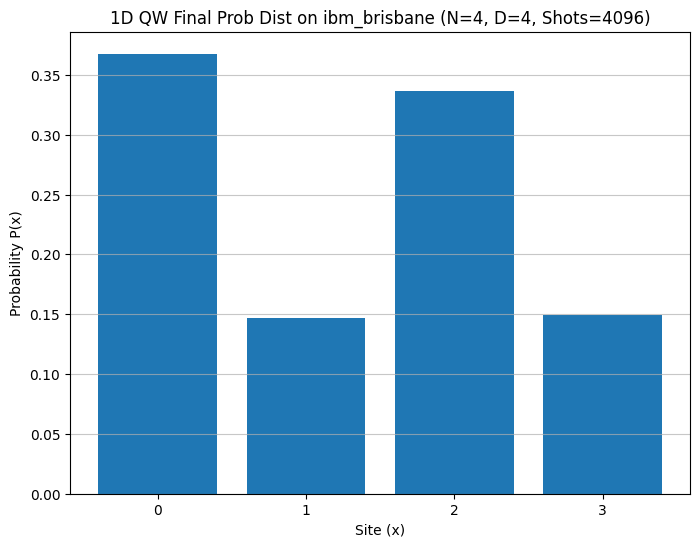


EXPERIMENT CONCLUDED. Please remember to invalidate the API token '99dd752798...' (used directly in this script) on the IBM Quantum website: https://quantum.ibm.com/account


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mpl_colors
import time
import os

# Qiskit imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator

try:
    from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, Session
    from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
    from qiskit_ibm_runtime.ibm_backend import IBMBackend as IBMRuntimeBackend
    qiskit_runtime_available = True
    print("Successfully imported Qiskit Runtime modules.")
except ImportError:
    print("CRITICAL WARNING: qiskit_ibm_runtime could not be imported. IBM Quantum execution will fail.")
    QiskitRuntimeService = None; Sampler = None; Session = None; generate_preset_pass_manager = None
    IBMRuntimeBackend = None
    qiskit_runtime_available = False

# --- Parameters for this test ---
N_SITES = 4 # Requires 2 position qubits
N_POS_QUBITS = (N_SITES - 1).bit_length() if N_SITES > 0 else 0
N_COIN_QUBITS = 1
TOTAL_QUBITS = N_POS_QUBITS + N_COIN_QUBITS
DEPTH = 4    # A few steps to see spreading

# --- IBM Quantum API Token and Instance Details ---
IBM_QUANTUM_TOKEN_DIRECT = 'API KEY HERE'
IBM_QUANTUM_CHANNEL_DIRECT = 'ibm_quantum'
IBM_QUANTUM_INSTANCE_DIRECT = 'ibm-q/open/main'

service = None
if qiskit_runtime_available:
    try:
        print(f"Attempting to initialize IBM QiskitRuntimeService directly with provided token for instance: {IBM_QUANTUM_INSTANCE_DIRECT}")
        service = QiskitRuntimeService(
            channel=IBM_QUANTUM_CHANNEL_DIRECT,
            instance=IBM_QUANTUM_INSTANCE_DIRECT,
            token=IBM_QUANTUM_TOKEN_DIRECT
        )
        print("IBM QiskitRuntimeService initialized directly with provided token.")
    except Exception as e:
        print(f"ERROR: Could not initialize QiskitRuntimeService directly with token: {e}")
        service = None
else:
    print("qiskit_ibm_runtime package is not available. Cannot use IBM Quantum Primitives.")

# --- Select Backend ---
backend = None
backend_name_to_print = "AerSimulator (local)"
backend_target_name = 'ibm_brisbane'
# backend_target_name = 'ibmq_qasm_simulator' # Try this if QPU fails or to test runtime flow

if service:
    try:
        print(f"\nAttempting to get a 'least_busy' SIMULATOR from QiskitRuntimeService (min {TOTAL_QUBITS} qubits)...")
        runtime_simulator_backend = service.least_busy(min_num_qubits=TOTAL_QUBITS, simulator=True, operational=None)
        if runtime_simulator_backend:
            backend = runtime_simulator_backend
            backend_name_to_print = backend.name
            print(f"Selected CLOUD SIMULATOR for Qiskit Runtime: {backend.name} (Qubits: {backend.num_qubits})")
        else:
            print("service.least_busy(simulator=True) did not return a backend.")
    except Exception as e_least_busy_sim:
        print(f"Error using service.least_busy(simulator=True): {e_least_busy_sim}")

    if backend is None:
        print(f"\nCloud simulator not found or selected. Attempting to get QPU backend: {backend_target_name}...")
        try:
            qpu_backend_obj = service.backend(backend_target_name)
            if qpu_backend_obj:
                backend = qpu_backend_obj
                backend_name_to_print = backend.name
                current_status = backend.status()
                print(f"Selected QPU backend for Qiskit Runtime: {backend.name} (Qubits: {backend.num_qubits}, Status: {current_status.status_msg})")
                if hasattr(backend, 'status') and callable(backend.status) and current_status.status_msg != 'active':
                    print(f"WARNING: QPU {backend.name} status is {current_status.status_msg}. May not be ideal for running jobs.")
            else:
                print(f"QPU backend {backend_target_name} not found or not available via service.")
                backend = None
        except Exception as e_qpu:
            print(f"Could not get QPU backend '{backend_target_name}': {e_qpu}")

if backend is None:
    print("\nNo cloud backend successfully obtained. Falling back to local AerSimulator.")
    backend = AerSimulator()
    backend_name_to_print = "AerSimulator (local)"

# --- Define Qubit Registers and Circuit ---
pos_q = QuantumRegister(N_POS_QUBITS, name='pos') # 2 qubits for N_SITES=4
coin_q = QuantumRegister(N_COIN_QUBITS, name='coin') # 1 qubit
cr_combined = ClassicalRegister(N_POS_QUBITS + N_COIN_QUBITS, name='meas_out')
qc = QuantumCircuit(pos_q, coin_q, cr_combined)

# --- Initial State ---
initial_pos_val = N_SITES // 2 # For N_SITES=4, this is 2 (binary 10)
print(f"\nN_SITES={N_SITES}, N_POS_QUBITS={N_POS_QUBITS}, Target initial_pos_val={initial_pos_val}")
for i in range(N_POS_QUBITS):
    if (initial_pos_val >> i) & 1: qc.x(pos_q[i])
# Initial coin state |0> (default)
qc.barrier(label="init")

# --- QW Step Definition (with corrected 2-qubit shift) ---
def apply_coin_step_qiskit(circuit, coin_qubit_obj):
    circuit.h(coin_qubit_obj)

def apply_shift_step_qiskit_N_pos2(circuit, coin_qubit, pos_qubits_list):
    if len(pos_qubits_list) != 2:
        raise ValueError("This shift function is specifically for 2 position qubits.")
    c = coin_qubit
    p0 = pos_qubits_list[0] # LSB
    p1 = pos_qubits_list[1] # MSB

    # --- Decrement if coin is |0> ---
    # Sequence for P-1 is X(p0); CX(p0,p1) but controlled by coin_is_0
    circuit.x(c) # Activate control for original coin |0>
    # Controlled X(p0):
    circuit.cx(c, p0)
    # Controlled CX(p0,p1):
    circuit.ccx(c, p0, p1)
    circuit.x(c) # Deactivate control (flip coin back)

    # --- Increment if coin is |1> ---
    # Sequence for P+1 is CX(p0,p1); X(p0) (order of application), controlled by coin_is_1
    # Controlled CX(p0,p1):
    circuit.ccx(c, p0, p1)
    # Controlled X(p0):
    circuit.cx(c, p0)

    circuit.barrier(label="shift_op")

# --- Evolution Loop ---
print(f"\nBuilding QW circuit with Depth={DEPTH}...")
for step in range(DEPTH):
    apply_coin_step_qiskit(qc, coin_q[0])
    if N_POS_QUBITS == 2:
        apply_shift_step_qiskit_N_pos2(qc, coin_q[0], pos_q)
    else:
        # Fallback to ultra-simple placeholder if not 2 position qubits
        print("WARNING: Using ultra-simplified shift for N_POS_QUBITS != 2")
        if len(pos_q) > 0: qc.cx(coin_q[0], pos_q[0])
        qc.barrier(label="shift_op_placeholder")
    if step < DEPTH - 1: qc.barrier(label=f"step_s{step}")

# --- Measurement ---
qc.measure(pos_q[:] + coin_q[:], cr_combined[:])

print("\n--- Generated QW Circuit ---")
try: print(qc.draw(output='text', fold=-1))
except Exception as e_draw: print(f"Could not draw circuit: {e_draw}")

# --- Transpile and Run ---
print(f"\n--- Transpiling and Running on {backend_name_to_print} ---")
counts = {}
try:
    shots = 4096 # Increased shots for QPU
    isa_circuit = qc
    is_runtime_target = False
    if qiskit_runtime_available and service and backend:
        if IBMRuntimeBackend and isinstance(backend, IBMRuntimeBackend): is_runtime_target = True
        elif hasattr(backend, 'provider') and "runtime" in str(type(backend.provider)).lower() and backend.name != "aer_simulator": is_runtime_target = True

    if is_runtime_target and generate_preset_pass_manager is not None:
        print("Transpiling for Qiskit Runtime backend using preset pass manager...")
        pm = generate_preset_pass_manager(backend=backend, optimization_level=1) # Basic optimization
        isa_circuit = pm.run(qc)
        print(f"QW circuit depth original: {qc.depth()}, transpiled (ISA): {isa_circuit.depth()}")
    elif isinstance(backend, AerSimulator):
        print(f"Basic transpilation for {backend_name_to_print}...")
        isa_circuit = transpile(qc, backend=backend, optimization_level=1)
        print(f"QW circuit depth original: {qc.depth()}, transpiled: {isa_circuit.depth()}")
    else:
        print(f"Using original circuit for {backend_name_to_print} (depth: {qc.depth()}).")

    if is_runtime_target and Sampler is not None and Session is not None :
        print(f"Using QiskitRuntimeService SamplerV2 for backend: {backend.name}")
        with Session(backend=backend) as session:
            sampler = Sampler()
            pub = (isa_circuit,)
            job = sampler.run([pub], shots=shots)
            print(f"Job ID: {job.job_id()} submitted to Qiskit Runtime.")
            print("Waiting for results...")
            result = job.result()
            print("Processing SamplerV2 results...")
            if result and len(result) > 0:
                pub_result = result[0]
                classical_register_name_in_circuit = cr_combined.name
                if hasattr(pub_result.data, classical_register_name_in_circuit):
                    bit_array_obj = getattr(pub_result.data, classical_register_name_in_circuit)
                    if bit_array_obj is not None: counts = bit_array_obj.get_counts()
                    else: print(f"WARNING: Data for '{classical_register_name_in_circuit}' is None."); counts = {}
                elif hasattr(pub_result.data, 'meas'):
                    bit_array_obj = pub_result.data.meas
                    if bit_array_obj is not None: counts = bit_array_obj.get_counts()
                    else: print("WARNING: Data for 'meas' is None."); counts = {}
                else: print(f"WARNING: No '{classical_register_name_in_circuit}' or 'meas' field. Attrs: {dir(pub_result.data)}"); counts = {}
            else: print("ERROR: Job result is None or empty from SamplerV2."); counts = {}
    elif isinstance(backend, AerSimulator):
        print(f"Using legacy backend.run() for {backend_name_to_print}")
        job = backend.run(isa_circuit, shots=shots)
        result = job.result()
        counts = result.get_counts(0)
    else:
        print(f"ERROR: No suitable execution path found. Backend: {backend.name if backend else 'None'}")
        counts = {}

    print("\n--- Results ---")
    print("Counts:", counts)

    print("\n--- Analysis (Example) ---")
    prob_dist_x = np.zeros(N_SITES)
    if counts:
        for bitstring, count_val in counts.items():
            if len(bitstring) == TOTAL_QUBITS:
                try:
                    # Qiskit bitstring from measure_all: MSB is for last qubit added to measure_all list
                    # Our measure list: pos_q[:] + coin_q[:]
                    # If pos_q=[p0,p1], coin_q=[c0], then measure list is [p0,p1,c0]
                    # Classical bits in cr_combined: cb0 for p0, cb1 for p1, cb2 for c0
                    # Bitstring key "b2b1b0" = "coin_val pos_val_MSB pos_val_LSB"

                    coin_binary_str = bitstring[:N_COIN_QUBITS] # First N_COIN_QUBITS bits are coin
                    pos_binary_str  = bitstring[N_COIN_QUBITS:]  # Remaining bits are position

                    measured_pos = int(pos_binary_str, 2) # pos_binary_str is "p_MSB...p_LSB"

                    if 0 <= measured_pos < N_SITES:
                        prob_dist_x[measured_pos] += count_val / shots
                    else: print(f"Warning: Parsed pos {measured_pos} from '{bitstring}' (pos_part='{pos_binary_str}') out of bounds for N_SITES={N_SITES}.")
                except ValueError as e_parse: print(f"Warning: Could not parse bitstring '{bitstring}': {e_parse}")
                except IndexError as e_idx: print(f"Warning: Index error parsing bitstring '{bitstring}': {e_idx}")
            else: print(f"Unexpected bitstring format/length: '{bitstring}' for TOTAL_QUBITS={TOTAL_QUBITS}")
    else: print("Counts dictionary is empty. Cannot calculate probability distribution.")

    if np.any(prob_dist_x) or not counts: # Plot even if all zero if counts dict existed
        plt.figure(figsize=(max(8, N_SITES*1.5),6))
        plt.bar(np.arange(N_SITES), prob_dist_x, width=0.8)
        plt.xlabel("Site (x)")
        plt.ylabel("Probability P(x)")
        plt.title(f"1D QW Final Prob Dist on {backend_name_to_print} (N={N_SITES}, D={DEPTH}, Shots={shots})")
        plt.xticks(np.arange(N_SITES))
        plt.grid(axis='y', alpha=0.7)
        plt.show()
    elif counts : print("Probability distribution is all zero (after parsing). Check circuit/parsing logic.")
    else: print("No counts data to plot.")

except Exception as main_e:
    print(f"An error occurred in the main script: {main_e}")
    import traceback
    traceback.print_exc()
finally:
    print(f"\nEXPERIMENT CONCLUDED. Please remember to invalidate the API token "
          f"'{IBM_QUANTUM_TOKEN_DIRECT[:10]}...' (used directly in this script) "
          f"on the IBM Quantum website: https://quantum.ibm.com/account")

Successfully imported Qiskit Runtime modules.
Attempting to initialize IBM QiskitRuntimeService directly with provided token for instance: ibm-q/open/main


<ipython-input-6-db83045d9565>:43: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, ibm_cloud will be the only valid channel. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(


IBM QiskitRuntimeService initialized directly with provided token.

Attempting to get QPU backend: ibm_brisbane from QiskitRuntimeService...
Selected QPU backend for Qiskit Runtime: ibm_brisbane (Qubits: 127, Status: active)

N_SITES=4, N_POS_QUBITS=2, Target initial_pos_val=2

Building QW circuit with Depth=2...

--- Generated QW Circuit ---
                  init       coin_op ┌───────┐                  ┌──────────┐┌───────┐                ┌──────────┐ qft_shift  step_s0       coin_op ┌───────┐                  ┌──────────┐┌───────┐                ┌──────────┐ qft_shift ┌─┐      
     pos_0: ───────░────────────░────┤0      ├─■────────────────┤0         ├┤0      ├─■──────────────┤0         ├─────░─────────░─────────────░────┤0      ├─■────────────────┤0         ├┤0      ├─■──────────────┤0         ├─────░─────┤M├──────
            ┌───┐  ░            ░    │  qft2 │ │                │  qft2_dg ││  qft2 │ │              │  qft2_dg │     ░         ░             ░    │  qft2 │ │         

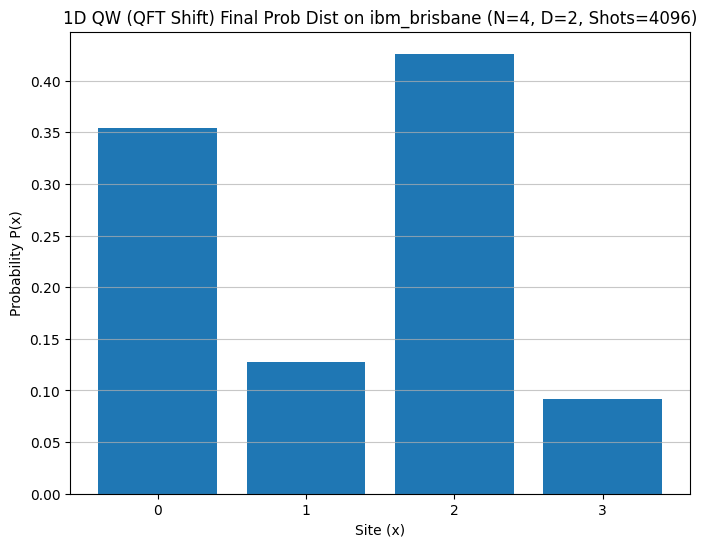


EXPERIMENT CONCLUDED. Please remember to invalidate the API token '99dd752798...' on the IBM Quantum website: https://quantum.ibm.com/account


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mpl_colors
import time
import os

# Qiskit imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import QFT

# Modern IBM Quantum access
try:
    from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, Session
    from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
    from qiskit_ibm_runtime.ibm_backend import IBMBackend as IBMRuntimeBackend
    qiskit_runtime_available = True
    print("Successfully imported Qiskit Runtime modules.")
except ImportError:
    print("CRITICAL WARNING: qiskit_ibm_runtime could not be imported. IBM Quantum execution will fail.")
    QiskitRuntimeService = None; Sampler = None; Session = None; generate_preset_pass_manager = None
    IBMRuntimeBackend = None
    qiskit_runtime_available = False

# --- Parameters for this QPU test ---
N_SITES = 4
N_POS_QUBITS = (N_SITES - 1).bit_length() if N_SITES > 0 else 0 # Should be 2
N_COIN_QUBITS = 1
TOTAL_QUBITS = N_POS_QUBITS + N_COIN_QUBITS # Should be 3
DEPTH = 2    # Number of QW steps for this QPU test
INITIAL_POS_VAL = N_SITES // 2 # Start at center (site 2 for N_SITES=4)
INITIAL_COIN_VAL = 0

# --- IBM Quantum API Token and Instance Details ---
IBM_QUANTUM_TOKEN_DIRECT = 'API KEY HERE'
IBM_QUANTUM_CHANNEL_DIRECT = 'ibm_quantum'
IBM_QUANTUM_INSTANCE_DIRECT = 'ibm-q/open/main'

service = None
if qiskit_runtime_available:
    try:
        print(f"Attempting to initialize IBM QiskitRuntimeService directly with provided token for instance: {IBM_QUANTUM_INSTANCE_DIRECT}")
        service = QiskitRuntimeService(
            channel=IBM_QUANTUM_CHANNEL_DIRECT,
            instance=IBM_QUANTUM_INSTANCE_DIRECT,
            token=IBM_QUANTUM_TOKEN_DIRECT
        )
        print("IBM QiskitRuntimeService initialized directly with provided token.")
    except Exception as e:
        print(f"ERROR: Could not initialize QiskitRuntimeService directly with token: {e}")
        service = None
else:
    print("qiskit_ibm_runtime package is not available. Cannot use IBM Quantum Primitives.")

# --- Select Backend ---
backend = None
backend_name_to_print = "AerSimulator (local)"
backend_target_name = 'ibm_brisbane'

if service:
    try:
        print(f"\nAttempting to get QPU backend: {backend_target_name} from QiskitRuntimeService...")
        qpu_backend_obj = service.backend(backend_target_name)
        if qpu_backend_obj:
            backend = qpu_backend_obj
            backend_name_to_print = backend.name
            current_status = backend.status()
            print(f"Selected QPU backend for Qiskit Runtime: {backend.name} (Qubits: {backend.num_qubits}, Status: {current_status.status_msg})")
            if hasattr(backend, 'status') and callable(backend.status) and current_status.status_msg != 'active':
                print(f"WARNING: QPU {backend.name} status is {current_status.status_msg}.")
        else:
            print(f"QPU backend {backend_target_name} not found or not available via service.")
            backend = None
    except Exception as e_qpu:
        print(f"Could not get QPU backend '{backend_target_name}': {e_qpu}")

if backend is None:
    print("\nNo QPU backend successfully obtained. Falling back to local AerSimulator.")
    backend = AerSimulator()
    backend_name_to_print = "AerSimulator (local)"

# --- Define Qubit Registers and Circuit ---
pos_q = QuantumRegister(N_POS_QUBITS, name='pos')
coin_q = QuantumRegister(N_COIN_QUBITS, name='coin')
cr_combined = ClassicalRegister(TOTAL_QUBITS, name='meas_out')
qc = QuantumCircuit(pos_q, coin_q, cr_combined)

# --- Initial State ---
print(f"\nN_SITES={N_SITES}, N_POS_QUBITS={N_POS_QUBITS}, Target initial_pos_val={INITIAL_POS_VAL}")
for i in range(N_POS_QUBITS):
    if (INITIAL_POS_VAL >> i) & 1: qc.x(pos_q[i])
if INITIAL_COIN_VAL == 1: qc.x(coin_q[0])
qc.barrier(label="init")

# --- QW Step Definition (Using QFT-based Shift) ---
def apply_hadamard_coin_qiskit(circuit, coin_qubit_obj):
    circuit.h(coin_qubit_obj)
    circuit.barrier(label="coin_op")

def apply_qft_shift_to_circuit(circuit, coin_qubit_obj, pos_register_list):
    n_pos = len(pos_register_list)
    if n_pos == 0: return

    qft_op = QFT(n_pos, do_swaps=False, name=f'qft{n_pos}')
    iqft_op = qft_op.inverse()

    # --- Decrement for coin |0> ---
    circuit.x(coin_qubit_obj)
    circuit.append(qft_op, pos_register_list)
    for j_fourier in range(n_pos):
        angle_decrement = -np.pi / (2**j_fourier)
        circuit.cp(angle_decrement, coin_qubit_obj, pos_register_list[j_fourier])
    circuit.append(iqft_op, pos_register_list)
    circuit.x(coin_qubit_obj)

    # --- Increment for coin |1> ---
    circuit.append(qft_op, pos_register_list)
    for j_fourier in range(n_pos):
        angle_increment = np.pi / (2**j_fourier)
        circuit.cp(angle_increment, coin_qubit_obj, pos_register_list[j_fourier])
    circuit.append(iqft_op, pos_register_list)

    circuit.barrier(label="qft_shift")

# --- Evolution Loop ---
print(f"\nBuilding QW circuit with Depth={DEPTH}...")
for step in range(DEPTH):
    apply_hadamard_coin_qiskit(qc, coin_q[0])
    apply_qft_shift_to_circuit(qc, coin_q[0], pos_q)
    if step < DEPTH - 1: qc.barrier(label=f"step_s{step}")

# --- Measurement ---
qc.measure(pos_q[:] + coin_q[:], cr_combined[:])

print("\n--- Generated QW Circuit ---")
try: print(qc.draw(output='text', fold=-1))
except Exception as e_draw: print(f"Could not draw circuit: {e_draw}")


# --- Transpile and Run ---
print(f"\n--- Transpiling and Running on {backend_name_to_print} ---")
counts = {}
try:
    shots = 4096 # Good number for QPU
    isa_circuit = qc
    is_runtime_target = False
    if qiskit_runtime_available and service and backend:
        if IBMRuntimeBackend and isinstance(backend, IBMRuntimeBackend): is_runtime_target = True
        elif hasattr(backend, 'provider') and "runtime" in str(type(backend.provider)).lower() and backend.name != "aer_simulator": is_runtime_target = True

    if is_runtime_target and generate_preset_pass_manager is not None:
        print("Transpiling for Qiskit Runtime backend using preset pass manager...")
        pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
        isa_circuit = pm.run(qc)
        print(f"QW circuit depth original: {qc.depth()}, transpiled (ISA): {isa_circuit.depth()}")
    elif isinstance(backend, AerSimulator):
        print(f"Basic transpilation for {backend_name_to_print}...")
        isa_circuit = transpile(qc, backend=backend, optimization_level=1)
        print(f"QW circuit depth original: {qc.depth()}, transpiled: {isa_circuit.depth()}")
    else:
        print(f"Using original circuit for {backend_name_to_print} (depth: {qc.depth()}).")

    if is_runtime_target and Sampler is not None and Session is not None :
        print(f"Using QiskitRuntimeService SamplerV2 for backend: {backend.name}")
        with Session(backend=backend) as session:
            sampler = Sampler()
            pub = (isa_circuit,)
            job = sampler.run([pub], shots=shots)
            print(f"Job ID: {job.job_id()} submitted to Qiskit Runtime.")
            print("Waiting for results...")
            result = job.result()
            print("Processing SamplerV2 results...")
            if result and len(result) > 0:
                pub_result = result[0]
                classical_register_name_in_circuit = cr_combined.name
                if hasattr(pub_result.data, classical_register_name_in_circuit):
                    bit_array_obj = getattr(pub_result.data, classical_register_name_in_circuit)
                    if bit_array_obj is not None: counts = bit_array_obj.get_counts()
                    else: print(f"WARNING: Data for '{classical_register_name_in_circuit}' is None."); counts = {}
                elif hasattr(pub_result.data, 'meas'):
                    bit_array_obj = pub_result.data.meas
                    if bit_array_obj is not None: counts = bit_array_obj.get_counts()
                    else: print("WARNING: Data for 'meas' is None."); counts = {}
                else: print(f"WARNING: No '{classical_register_name_in_circuit}' or 'meas' field. Attrs: {dir(pub_result.data)}"); counts = {}
            else: print("ERROR: Job result is None or empty from SamplerV2."); counts = {}
    elif isinstance(backend, AerSimulator):
        print(f"Using legacy backend.run() for {backend_name_to_print}")
        job = backend.run(isa_circuit, shots=shots)
        result = job.result()
        counts = result.get_counts(0)
    else:
        print(f"ERROR: No suitable execution path found. Backend: {backend.name if backend else 'None'}")
        counts = {}

    print("\n--- Results ---")
    print("Counts:", counts)

    # --- Process and Analyze Results ---
    print("\n--- Analysis ---")
    prob_dist_x = np.zeros(N_SITES)
    if counts:
        for bitstring, count_val in counts.items():
            if len(bitstring) == TOTAL_QUBITS:
                try:
                    # Bitstring from Qiskit counts: MSB on left, LSB on right.
                    # Classical bits map to circuit qubits in the order they were added to measure_all list.
                    # Our measure list: pos_q[0], pos_q[1], ..., coin_q[0]
                    # So, coin bit is the MSB (leftmost bit of the string if TOTAL_QUBITS is the length)

                    coin_binary_str = bitstring[:N_COIN_QUBITS] # First N_COIN_QUBITS bits
                    pos_binary_str  = bitstring[N_COIN_QUBITS:]  # Remaining bits

                    measured_pos = int(pos_binary_str, 2) # pos_binary_str is "p_MSB...p_LSB"

                    if 0 <= measured_pos < N_SITES:
                        prob_dist_x[measured_pos] += count_val / shots
                    else: print(f"Warning: Parsed pos {measured_pos} from '{bitstring}' (pos_part='{pos_binary_str}') out of bounds for N_SITES={N_SITES}.")
                except ValueError as e_parse: print(f"Warning: Could not parse bitstring '{bitstring}': {e_parse}")
                except IndexError as e_idx: print(f"Warning: Index error parsing bitstring '{bitstring}': {e_idx}")
            else: print(f"Unexpected bitstring format/length: '{bitstring}' for TOTAL_QUBITS={TOTAL_QUBITS}")
    else:
        print("Counts dictionary is empty. Cannot calculate probability distribution.")

    if np.any(prob_dist_x) or not counts :
        plt.figure(figsize=(max(8, N_SITES*1.2),6))
        plt.bar(np.arange(N_SITES), prob_dist_x, width=0.8)
        plt.xlabel("Site (x)")
        plt.ylabel("Probability P(x)")
        plt.title(f"1D QW (QFT Shift) Final Prob Dist on {backend_name_to_print} (N={N_SITES}, D={DEPTH}, Shots={shots})")
        plt.xticks(np.arange(N_SITES))
        plt.grid(axis='y', alpha=0.7)
        plt.show()
    elif counts : print("Probability distribution is all zero (after parsing). Check circuit/parsing logic.")
    else: print("No counts data to plot.")

except Exception as main_e:
    print(f"An error occurred in the main script: {main_e}")
    import traceback
    traceback.print_exc()
finally:
    print(f"\nEXPERIMENT CONCLUDED. Please remember to invalidate the API token "
          f"'{IBM_QUANTUM_TOKEN_DIRECT[:10]}...' "
          f"on the IBM Quantum website: https://quantum.ibm.com/account")